# Probability Calibration

In supervised learning, sometimes we might be interested in the output probability and not the predicted class. For example, let's say we build a model to predict the likelihood of an estate agency selling a property at `£500,000`. To calculate the expected revenue, we will require the formula

$ 𝚺 xᵢ * P(X = xᵢ) $

where 
xᵢ: price of property
P(X = xᵢ): likelihood of selling the property at price xᵢ

In such a case, it is really important to work with "well calibrated probabilities". How do you define a well calibrated probability?

*In very simple terms, these are probabilities which can be interpreted as a confidence interval. Furthermore, a classifier is said to produce well calibrated probabilities if for the instances (data points) receiving probability 0.5, 50% of those instances belongs to the positive class.*

In this tutorial I will talk about how to obtain calibrated probabilities using the credit card defaults dataset, which can be found __[here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)__ but first some background on probability calibration.

Probability calibration is essential if the required output is the true probability and not the ranking or predicted class as calibration does not change probability ranks or class with the maximum probability. Not all classifiers produce well calibrated probabilities and for some classifiers the predicted probability does not match the output of its decision function (for example SVC). 
Logistics regression is popularly known to produce well calibrated probabilities if and only if the parametric assumptions of the model holds. Naive Bayes is notorious for producing probabilities close to its extremes i.e. 0 and 1 while boosting and bagging techniques are known for producing probabilities away from 0 and 1 hence requires calibration. To better understand how well various classifiers are calibrated, I'd strongly recommend this __[page](https://scikit-learn.org/stable/modules/calibration.html)__.

There are 2 popular methods for calibrating probabilities:

**Platt scaling**: aka logistic calibration is a parametric approach with a sigmoidal calibration map which assumes each class probabilities are normally distributed. In simple terms, this method fits a logistic regression to output probabilities to produce better calibrated probabilities.

*Pro-*
Works well with small dataset

*Con-*
Could produce worse probabilities calibration wise if the assumptions do not hold

**Isotonic regression**: this is a non parametric approach which tends to perform well with as it fits a piece wise non-decreasing function to the predicted probabilities outputted by the base model.

*Pro-*
Makes no assumption about the input probabilities

*Con-*
Requires more datapoints to work well



Now let's get into the dataset. We will:
 -  Load the dataset
 - Apply some basic preprocessing
 - Build a random forest model which predicts the likelihood of an individual defaulting on their credit card payment
 - Calibrate the probabilities
 
 First let's import relevant packages.

In [1]:
import numpy as np
import pandas as pd

from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report,roc_auc_score
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

The cell below is a way of restricting how many columns are displayed when inspecting a dataframe. 

In [2]:
pd.options.display.max_columns = None

### 1. Load dataset and inspect first 5 rows

In [3]:
data = pd.read_excel("credit_card_defaults.xls", header=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 2. Prep data for modelling

For simplicity, we will only be working with numerical features as the goal is to demo calibration techniques and not build the most optimal model.

In [4]:
model_features = list(set(data.columns).difference({"ID", "default payment next month", "SEX", "EDUCATION", "MARRIAGE"}))
target = ["default payment next month"]

As per good practise, I have split the data into train and test set using scikit-learn's `train_test_split`. However as we will be fitting a calibration model, we require another dataset to be used for this fitting to avoid overfitting. To achieve this, I further split the train dataset into train and validation set as below:

In [5]:
X = data[model_features]
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

# Create a hold out dataset to train the calibrated model to prevent overfitting
x_model_train, x_valid, y_model_train, y_valid = train_test_split(x_train, y_train, stratify=y_train, random_state=12)

### 3. Fit random forest model

Further work can be done here to identify the optimal parameters for the random forest classifier.

In [6]:
rf_clf = RandomForestClassifier(n_estimators=100, 
                                max_depth=6, 
                                min_samples_split=200, 
                                random_state=12, 
                                class_weight="balanced")

rf_clf.fit(x_model_train, y_model_train)

rf_predictions = rf_clf.predict_proba(x_test)
rf_roc_score = roc_auc_score(y_test, rf_predictions[:,1])

print(f"ROC score for random forest model is {rf_roc_score}")

ROC score for random forest model is 0.7730542003230267


### 4. Fit calibration model

There are 2 way of using the sklearn `CalibratedClassifierCV` class:

- Pass a fitted model and thereby setting cv to `prefit`. It is important to note that the data used in fitting the base estimator and the calibrator is disjoint.

- Fit a base estimator using k-fold cross-validation and the probabilities for each of the folds are then averaged for prediction.

The `method` parameter is one of the two methods discussed earlier for calibrating probabilities where `sigmoid` is platt scaling and `isotonic` for isotonic regression

For this demo, we will be using the first method using the fitted random forest classifier and platt scaling.

In [7]:
calib_clf = CalibratedClassifierCV(rf_clf, method="isotonic", cv="prefit")

calib_clf.fit(x_valid, y_valid)
calibrated_predictions = calib_clf.predict_proba(x_test)

calib_roc_score = roc_auc_score(y_test, calibrated_predictions[:,1])
print(f"ROC score for calibrated model is {calib_roc_score}")

ROC score for calibrated model is 0.7729070932246216


### 5. Plot reliability curve

A popular way of diagnosing how well calibrated probabilities are is by using reliability curve. Fortunately for us, there is an sklearn implementation for this which can be found __[here](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html)__

A perfectly calibrated classifier has a reliability plot of the form $y = x$.


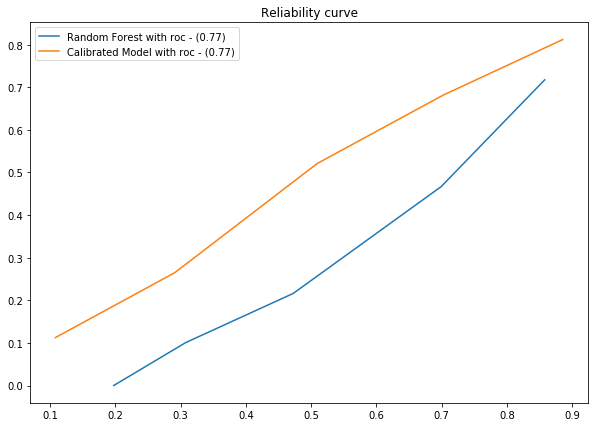

In [8]:
fig = plt.figure(figsize=(10, 7))

for outcomes, models, roc_scores in zip([rf_predictions, calibrated_predictions], 
                                        ["Random Forest", "Calibrated Model"],
                                       [rf_roc_score, calib_roc_score]):
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, outcomes[:,1])
    plt.plot(mean_predicted_value, fraction_of_positives, label="%s with roc - (%1.2f)" % (models, roc_scores))
    plt.legend()
    plt.title("Reliability curve")
plt.show()

Looking at the plot above, it is evident that we get better calibrated probabilities after applying isotonic regression. 

**Beware:**

Because platt scaling is a parametric method if the output model probabilities fail the assumption, it could produce 'calibrated' probabilities worse than the original probabilities from the base estimator